Mount Google Drive (Connects your Google Drive to Colab so you can load or save files)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy project files from Drive (Copies model and dataset files from your Drive folders into the Colab workspace)

In [ ]:
# Copy models from xgb_models
!cp /content/drive/My\ Drive/xgb_models/*.json .

# Copy everything from recsys_project (npy, csv, etc.)
!cp /content/drive/My\ Drive/recsys_project/* .


Exploratory Data Analysis (Analyzes user-book interactions and item metadata using plots, basic stats, and data previews)

Interactions Data Shape: (87047, 3)
Items Metadata Shape: (15291, 6)

Interactions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87047 entries, 0 to 87046
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   u       87047 non-null  int64  
 1   i       87047 non-null  int64  
 2   t       87047 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB
None

Items Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       15291 non-null  object
 1   Author      12638 non-null  object
 2   ISBN Valid  14568 non-null  object
 3   Publisher   15266 non-null  object
 4   Subjects    13068 non-null  object
 5   i           15291 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 716.9+ KB
None

Sample Interactions:
      u      i             t
0  4456   8581

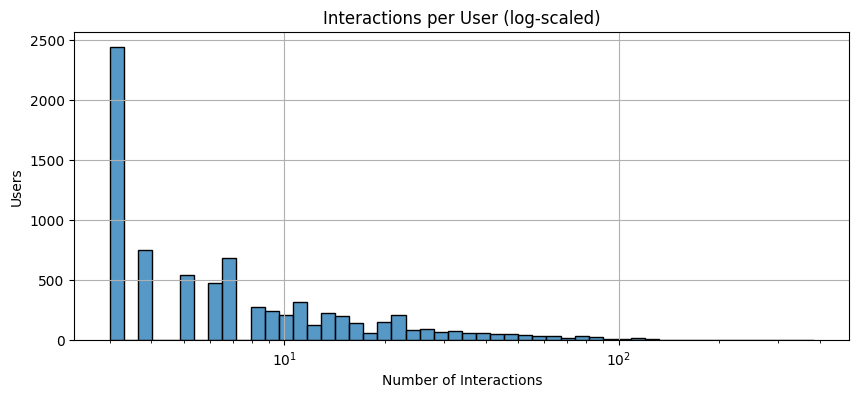

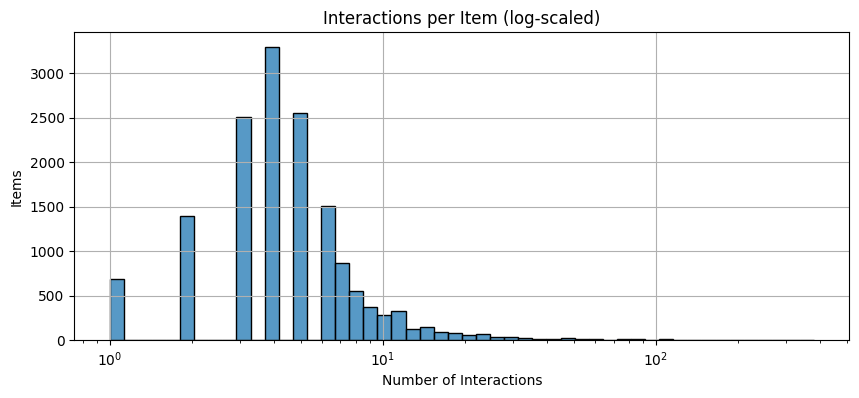

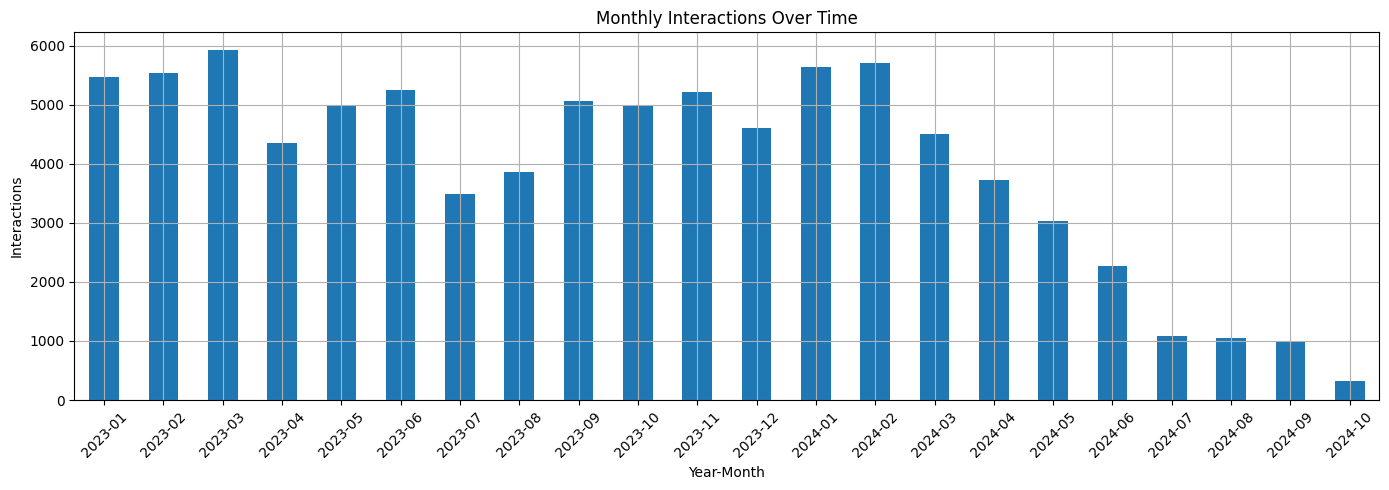


Missing Values in Items Metadata:
Title            0
Author        2653
ISBN Valid     723
Publisher       25
Subjects      2223
i                0
dtype: int64


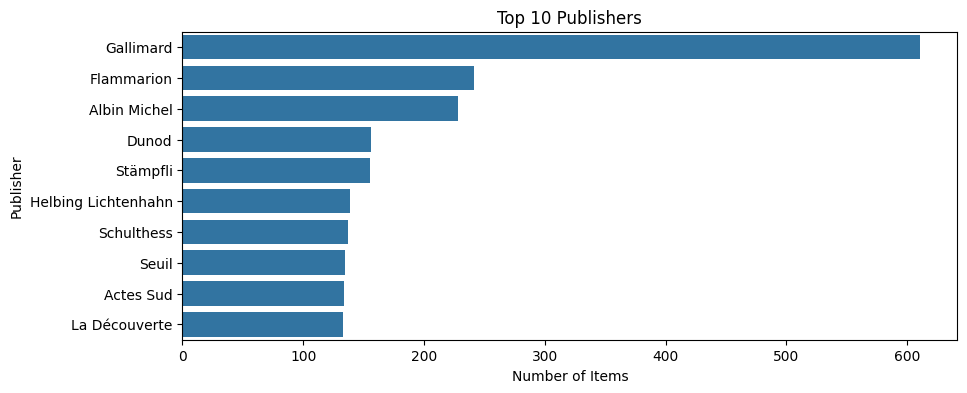

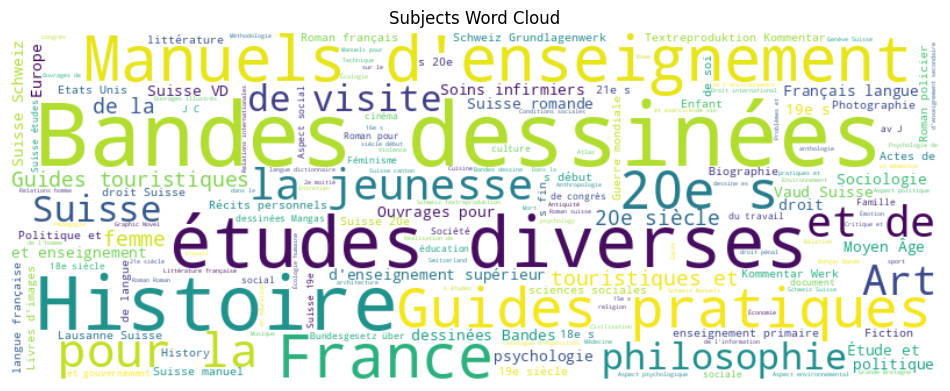


Sample Merged Data:
      u      i                                              Title  \
0  4456   8581                        Ashes falling for the sky /   
1   142   1964                                  La page blanche /   
2   362   3705                                   Aysuun : roman /   
3  1809  11317                   Le cercle des rêveurs éveillés /   
4  4384   1323  L'examen clinique de l'aîné : guide d'évaluati...   

      Publisher            datetime  
0  Albin Michel 2023-06-23 17:24:46  
1      Delcourt 2023-03-23 15:30:06  
2  Albin Michel 2024-02-02 11:00:59  
3     Gallimard 2023-01-12 14:19:22  
4       Pearson 2023-04-13 16:09:22  


In [ ]:
# ================================
# Setup and Data Loading
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io

# Load datasets
interactions_df = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items_df = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")

# ================================
# Basic Information
# ================================
print("Interactions Data Shape:", interactions_df.shape)
print("Items Metadata Shape:", items_df.shape)

print("\nInteractions Info:")
print(interactions_df.info())

print("\nItems Info:")
print(items_df.info())

print("\nSample Interactions:")
print(interactions_df.head())

print("\nSample Items:")
print(items_df.head())

# ================================
# Interactions EDA
# ================================
# Convert timestamp to datetime
interactions_df['datetime'] = pd.to_datetime(interactions_df['t'], unit='s')

# Basic stats
num_users = interactions_df['u'].nunique()
num_items = interactions_df['i'].nunique()
total_interactions = len(interactions_df)

print(f"\nUnique Users: {num_users}")
print(f"Unique Items: {num_items}")
print(f"Total Interactions: {total_interactions}")

# Interactions per user
user_interaction_counts = interactions_df['u'].value_counts()
plt.figure(figsize=(10, 4))
sns.histplot(user_interaction_counts, bins=50, log_scale=(True, False))
plt.title("Interactions per User (log-scaled)")
plt.xlabel("Number of Interactions")
plt.ylabel("Users")
plt.grid(True)
plt.show()

# Interactions per item
item_interaction_counts = interactions_df['i'].value_counts()
plt.figure(figsize=(10, 4))
sns.histplot(item_interaction_counts, bins=50, log_scale=(True, False))
plt.title("Interactions per Item (log-scaled)")
plt.xlabel("Number of Interactions")
plt.ylabel("Items")
plt.grid(True)
plt.show()

# Time-based analysis
interactions_df['year_month'] = interactions_df['datetime'].dt.to_period('M')
monthly_counts = interactions_df['year_month'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
monthly_counts.plot(kind='bar')
plt.title("Monthly Interactions Over Time")
plt.ylabel("Interactions")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# ================================
# Items Metadata EDA
# ================================
print("\nMissing Values in Items Metadata:")
print(items_df.isnull().sum())

# Top publishers
top_publishers = items_df['Publisher'].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title("Top 10 Publishers")
plt.xlabel("Number of Items")
plt.ylabel("Publisher")
plt.show()

# Subjects word cloud (optional)
try:
    from wordcloud import WordCloud
    all_subjects = ' '.join(items_df['Subjects'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=300, background_color='white').generate(all_subjects)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Subjects Word Cloud")
    plt.show()
except ImportError:
    print("Install `wordcloud` to visualize subjects.")

# ================================
# Merge Preview (Optional)
# ================================
merged = interactions_df.merge(items_df, on='i', how='left')
print("\nSample Merged Data:")
print(merged[['u', 'i', 'Title', 'Publisher', 'datetime']].head())


Item-based Collaborative Filtering (Generates top-10 book recommendations for each user using item-item cosine similarity and excludes already seen items)

In [ ]:
# Set URLs to GitHub
interactions_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv"
items_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv"
sample_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv"

# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from tqdm import tqdm

# Load data from GitHub
interactions = pd.read_csv(interactions_url)
items = pd.read_csv(items_url)
sample = pd.read_csv(sample_url)

# Build implicit binary interaction matrix
interactions['interaction'] = 1
n_users = interactions['u'].max() + 1
n_items = interactions['i'].max() + 1
user_item_matrix = csr_matrix(
    (interactions['interaction'], (interactions['u'], interactions['i'])),
    shape=(n_users, n_items)
)

# Compute item-item similarity (cosine)
item_similarity = cosine_similarity(user_item_matrix.T, dense_output=False)

# Recommend top-10 items for each user
user_ids = sample['user_id'].values
top_k = 10
recommendations = []

for user_id in tqdm(user_ids, desc="Generating recommendations"):
    user_interactions = user_item_matrix[user_id]
    scores = user_interactions.dot(item_similarity)
    scores = np.array(scores.todense()).flatten()

    # Exclude already seen items
    seen_items = user_interactions.indices
    scores[seen_items] = -np.inf

    # Get top-10
    top_items = np.argpartition(scores, -top_k)[-top_k:]
    top_items = top_items[np.argsort(-scores[top_items])]
    recommendations.append(" ".join(map(str, top_items)))

# Prepare submission
submission = sample.copy()
submission["recommendation"] = recommendations
submission.to_csv("cf_submission.csv", index=False)
print("✅ CF submission saved to 'cf_submission.csv'")


Generating recommendations: 100%|██████████| 7838/7838 [00:10<00:00, 778.56it/s]


✅ CF submission saved to 'cf_submission.csv'


TF-IDF Content-Based Filtering (Recommends books by comparing TF-IDF text similarity between items a user liked and all others, using title and subject metadata)

In [ ]:
# Set URLs to GitHub
interactions_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv"
items_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv"
sample_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv"

# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load data
interactions = pd.read_csv(interactions_url)
items = pd.read_csv(items_url)
sample = pd.read_csv(sample_url)

# Merge Title + Subjects (fill NaN)
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].values
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(items['text'])

# Build user → list of interacted item indices
user_items = interactions.groupby('u')['i'].apply(list).to_dict()

# Recommend top-10 items for each user
user_ids = sample['user_id'].values
top_k = 10
recommendations = []

for user_id in tqdm(user_ids, desc="Generating TF-IDF recommendations"):
    item_ids_seen = user_items.get(user_id, [])
    seen_indices = [item_id_to_index[i] for i in item_ids_seen if i in item_id_to_index]

    if seen_indices:
        user_vector = np.asarray(tfidf_matrix[seen_indices].mean(axis=0))
        scores = cosine_similarity(user_vector, tfidf_matrix).flatten()

        # Remove already-seen items
        for idx in seen_indices:
            scores[idx] = -np.inf

        top_indices = np.argpartition(scores, -top_k)[-top_k:]
        top_indices = top_indices[np.argsort(-scores[top_indices])]
        top_items = [index_to_item_id[i] for i in top_indices]
    else:
        top_items = list(items['i'].sample(top_k, random_state=42))

    recommendations.append(" ".join(map(str, top_items)))


# Create submission
submission = sample.copy()
submission["recommendation"] = recommendations
submission.to_csv("tfidf_submission.csv", index=False)
print("✅ TF-IDF submission saved to 'tfidf_submission.csv'")


Generating TF-IDF recommendations: 100%|██████████| 7838/7838 [00:22<00:00, 340.97it/s]

✅ TF-IDF submission saved to 'tfidf_submission.csv'


BERT-Based Semantic Filtering (Recommends books using semantic similarity of titles and subjects encoded with BERT embeddings, averaged per user)

In [ ]:
# Install sentence-transformers if not already installed
!pip install -q sentence-transformers

# Set GitHub URLs
interactions_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv"
items_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv"
sample_url = "https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv"

# Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load data
interactions = pd.read_csv(interactions_url)
items = pd.read_csv(items_url)
sample = pd.read_csv(sample_url)

# Prepare item texts
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].values
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}

# Encode items with BERT
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast
item_embeddings = model.encode(items['text'].tolist(), show_progress_bar=True, batch_size=64)

# Map user to list of seen item indices
user_items = interactions.groupby('u')['i'].apply(list).to_dict()

# Generate top-10 recommendations per user
user_ids = sample['user_id'].values
top_k = 10
recommendations = []

for user_id in tqdm(user_ids, desc="Generating BERT recommendations"):
    seen_items = user_items.get(user_id, [])
    seen_indices = [item_id_to_index[i] for i in seen_items if i in item_id_to_index]

    if seen_indices:
        user_embedding = np.mean(item_embeddings[seen_indices], axis=0).reshape(1, -1)
        scores = cosine_similarity(user_embedding, item_embeddings).flatten()

        for idx in seen_indices:
            scores[idx] = -np.inf  # exclude seen items

        top_indices = np.argpartition(scores, -top_k)[-top_k:]
        top_indices = top_indices[np.argsort(-scores[top_indices])]
        top_items = [index_to_item_id[i] for i in top_indices]
    else:
        top_items = list(items['i'].sample(top_k, random_state=42))

    recommendations.append(" ".join(map(str, top_items)))

# Create submission
submission = sample.copy()
submission["recommendation"] = recommendations
submission.to_csv("bert_submission.csv", index=False)
print("✅ BERT submission saved to 'bert_submission.csv'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 827.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/239 [00:00<?, ?it/s]

Generating BERT recommendations: 100%|██████████| 7838/7838 [03:49<00:00, 34.20it/s]


✅ BERT submission saved to 'bert_submission.csv'


Precompute Similarity Scores (Generates CF, TF-IDF, and BERT-based similarity scores for all user-item pairs to be used in hybrid recommendation models)

In [ ]:
!pip install -q sentence-transformers

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")

# Preprocess items
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].values
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
n_users = interactions['u'].max() + 1
n_items = len(item_ids)

# === CF Scores ===
interactions['interaction'] = 1
user_item_matrix = csr_matrix((interactions['interaction'], (interactions['u'], interactions['i'])), shape=(n_users, n_items))
item_similarity = cosine_similarity(user_item_matrix.T)
cf_scores = user_item_matrix.dot(item_similarity)
pd.DataFrame(cf_scores).to_csv("cf_scores.csv", index=False)

# === TF-IDF Scores ===
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(items['text'])
tfidf_scores = np.zeros((n_users, n_items))
user_items = interactions.groupby('u')['i'].apply(list).to_dict()
for u in range(n_users):
    seen = user_items.get(u, [])
    seen_indices = [item_id_to_index[i] for i in seen if i in item_id_to_index]
    if seen_indices:
        profile = np.asarray(tfidf_matrix[seen_indices].mean(axis=0))
        tfidf_scores[u] = cosine_similarity(profile, tfidf_matrix).flatten()
pd.DataFrame(tfidf_scores).to_csv("tfidf_scores.csv", index=False)

# === BERT Scores ===
model = SentenceTransformer('all-MiniLM-L6-v2')
item_embeddings = model.encode(items['text'].tolist(), show_progress_bar=True)
bert_scores = np.zeros((n_users, n_items))
for u in tqdm(range(n_users), desc="BERT scoring"):
    seen = user_items.get(u, [])
    seen_indices = [item_id_to_index[i] for i in seen if i in item_id_to_index]
    if seen_indices:
        profile = np.mean(item_embeddings[seen_indices], axis=0, keepdims=True)
        bert_scores[u] = cosine_similarity(profile, item_embeddings).flatten()
pd.DataFrame(bert_scores).to_csv("bert_scores.csv", index=False)

print("✅ All scores saved. Ready for blending.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/478 [00:00<?, ?it/s]

BERT scoring: 100%|██████████| 7838/7838 [03:57<00:00, 32.97it/s]


✅ All scores saved. Ready for blending.


Hybrid Score Blending (Combines CF, TF-IDF, and BERT scores with different weight combinations to generate multiple blended recommendation submissions)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load score matrices
cf = pd.read_csv("cf_scores.csv").values
tfidf = pd.read_csv("tfidf_scores.csv").values
bert = pd.read_csv("bert_scores.csv").values

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
item_ids = items['i'].tolist()

# Map user to seen items
user_seen = interactions.groupby('u')['i'].apply(set).to_dict()

# Define blending weights
lambda_combos = [
    (0.6, 0.2, 0.2),
    (0.5, 0.3, 0.2),
    (0.4, 0.4, 0.2),
    (0.4, 0.3, 0.3),
    (0.3, 0.4, 0.3),
    (0.33, 0.33, 0.34),
    (0.5, 0.25, 0.25),
]

top_k = 10

# Run blending for each lambda combo
for lam_cf, lam_tfidf, lam_bert in lambda_combos:
    blended = lam_cf * cf + lam_tfidf * tfidf + lam_bert * bert
    recommendations = []

    for user_id in tqdm(sample['user_id'], desc=f"Blending {lam_cf:.2f} / {lam_tfidf:.2f} / {lam_bert:.2f}"):
        scores = blended[user_id].copy()
        seen = user_seen.get(user_id, set())
        for item in seen:
            if item < len(scores):
                scores[item] = -np.inf
        top_items = np.argpartition(scores, -top_k)[-top_k:]
        top_items = top_items[np.argsort(-scores[top_items])]
        recommendations.append(" ".join(map(str, top_items)))

    filename = f"hybrid_{int(lam_cf*100):03}_{int(lam_tfidf*100):03}_{int(lam_bert*100):03}.csv"
    submission = sample.copy()
    submission["recommendation"] = recommendations
    submission.to_csv(filename, index=False)
    print(f"✅ Saved {filename}")


Blending 0.60 / 0.20 / 0.20: 100%|██████████| 7838/7838 [00:04<00:00, 1710.62it/s]


✅ Saved hybrid_060_020_020.csv


Blending 0.50 / 0.30 / 0.20: 100%|██████████| 7838/7838 [00:08<00:00, 877.26it/s] 


✅ Saved hybrid_050_030_020.csv


Blending 0.40 / 0.40 / 0.20: 100%|██████████| 7838/7838 [00:03<00:00, 2521.68it/s]


✅ Saved hybrid_040_040_020.csv


Blending 0.40 / 0.30 / 0.30: 100%|██████████| 7838/7838 [00:03<00:00, 2064.99it/s]


✅ Saved hybrid_040_030_030.csv


Blending 0.30 / 0.40 / 0.30: 100%|██████████| 7838/7838 [00:03<00:00, 2252.42it/s]


✅ Saved hybrid_030_040_030.csv


Blending 0.33 / 0.33 / 0.34: 100%|██████████| 7838/7838 [00:03<00:00, 2506.04it/s]


✅ Saved hybrid_033_033_034.csv


Blending 0.50 / 0.25 / 0.25: 100%|██████████| 7838/7838 [00:03<00:00, 2009.95it/s]

✅ Saved hybrid_050_025_025.csv


SVD-Based Collaborative Filtering (Uses matrix factorization with Truncated SVD to learn user/item embeddings and recommend top unseen books)

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load interaction and submission data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
item_ids = items['i'].tolist()

# Build user-item matrix
n_users = interactions['u'].max() + 1
n_items = items['i'].max() + 1
interactions['interaction'] = 1
user_item_matrix = csr_matrix((interactions['interaction'], (interactions['u'], interactions['i'])), shape=(n_users, n_items))

# SVD decomposition
n_components = 100  # Embedding dimension
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_embeddings = svd.fit_transform(user_item_matrix)
item_embeddings = svd.components_.T  # shape: (n_items, n_components)

# Score: dot product
scores = np.dot(user_embeddings, item_embeddings.T)

# Remove already seen items
user_seen = interactions.groupby('u')['i'].apply(set).to_dict()
top_k = 10
recommendations = []

for user_id in tqdm(sample['user_id'], desc="Generating SVD-CF recommendations"):
    user_scores = scores[user_id].copy()
    seen_items = user_seen.get(user_id, set())
    for item in seen_items:
        if item < len(user_scores):
            user_scores[item] = -np.inf
    top_items = np.argpartition(user_scores, -top_k)[-top_k:]
    top_items = top_items[np.argsort(-user_scores[top_items])]
    recommendations.append(" ".join(map(str, top_items)))

# Save submission
submission = sample.copy()
submission["recommendation"] = recommendations
submission.to_csv("svd_cf_submission.csv", index=False)
print("✅ SVD-based CF submission saved as 'svd_cf_submission.csv'")


Generating SVD-CF recommendations: 100%|██████████| 7838/7838 [00:00<00:00, 9996.37it/s] 


✅ SVD-based CF submission saved as 'svd_cf_submission.csv'


TF-IDF with SVD Dimensionality Reduction (Combines TF-IDF text features with SVD to generate compressed item embeddings for cosine-based content recommendations)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")

# Prepare item text
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].values
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_sparse = vectorizer.fit_transform(items['text'])

# Compress to dense embeddings via SVD
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
item_embeddings = svd.fit_transform(tfidf_sparse)

# Build user → list of seen item indices
user_items = interactions.groupby('u')['i'].apply(list).to_dict()
n_users = interactions['u'].max() + 1
n_items = len(item_ids)

# Compute scores via cosine similarity between user profile and all items
top_k = 10
recommendations = []

for u in tqdm(sample['user_id'], desc="TF-IDF (SVD) recommendations"):
    seen = user_items.get(u, [])
    seen_indices = [item_id_to_index[i] for i in seen if i in item_id_to_index]
    if seen_indices:
        user_profile = np.mean(item_embeddings[seen_indices], axis=0, keepdims=True)
        scores = cosine_similarity(user_profile, item_embeddings).flatten()
        for idx in seen_indices:
            scores[idx] = -np.inf
        top_items = np.argpartition(scores, -top_k)[-top_k:]
        top_items = top_items[np.argsort(-scores[top_items])]
        top_item_ids = [index_to_item_id[i] for i in top_items]
    else:
        top_item_ids = list(items['i'].sample(top_k, random_state=42))
    recommendations.append(" ".join(map(str, top_item_ids)))

# Save submission
submission = sample.copy()
submission["recommendation"] = recommendations
submission.to_csv("svd_tfidf_submission.csv", index=False)
print("✅ TF-IDF with SVD submission saved as 'svd_tfidf_submission.csv'")


TF-IDF (SVD) recommendations: 100%|██████████| 7838/7838 [02:22<00:00, 54.83it/s]

✅ TF-IDF with SVD submission saved as 'svd_tfidf_submission.csv'


Hybrid Ensemble Model with SVD and BERT (Combines predictions from SVD-based CF, TF-IDF with SVD, and BERT embeddings using different blending weights to generate final recommendations)

In [ ]:
!pip install -q sentence-transformers

import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load items & interactions
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")

# Build item text and index map
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].tolist()
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}
n_items = len(item_ids)
n_users = interactions['u'].max() + 1

# Load SVD_CF and SVD_TFIDF submissions
svd_cf = pd.read_csv("svd_cf_submission.csv")
svd_tfidf = pd.read_csv("svd_tfidf_submission.csv")

# Rebuild scores from rank positions (simple heuristic)
def submission_to_score_matrix(df):
    scores = np.zeros((n_users, n_items))
    for _, row in df.iterrows():
        user = row['user_id']
        item_list = list(map(int, row['recommendation'].split()))
        for rank, item in enumerate(item_list):
            if item in item_id_to_index:
                scores[user, item_id_to_index[item]] = 1.0 / (rank + 1)
    return scores

cf_scores = submission_to_score_matrix(svd_cf)
tfidf_scores = submission_to_score_matrix(svd_tfidf)

# Recompute BERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
item_embeddings = model.encode(items['text'].tolist(), show_progress_bar=True)
user_items = interactions.groupby('u')['i'].apply(list).to_dict()

bert_scores = np.zeros((n_users, n_items))
for u in tqdm(sample['user_id'], desc="Computing BERT scores"):
    seen_indices = [item_id_to_index[i] for i in user_items.get(u, []) if i in item_id_to_index]
    if seen_indices:
        user_vec = np.mean(item_embeddings[seen_indices], axis=0, keepdims=True)
        bert_scores[u] = cosine_similarity(user_vec, item_embeddings).flatten()

# Create user_seen map
user_seen = interactions.groupby('u')['i'].apply(set).to_dict()

# Blending weights
lambda_combos = [
    (0.4, 0.4, 0.2),
    (0.3, 0.4, 0.3),
    (0.33, 0.33, 0.34),
    (0.25, 0.5, 0.25),
    (0.3, 0.3, 0.4),
]

top_k = 10

# Blend and generate submissions
for lam_cf, lam_tfidf, lam_bert in lambda_combos:
    blended = lam_cf * cf_scores + lam_tfidf * tfidf_scores + lam_bert * bert_scores
    recommendations = []

    for user_id in tqdm(sample['user_id'], desc=f"Blending {lam_cf:.2f}/{lam_tfidf:.2f}/{lam_bert:.2f}"):
        user_scores = blended[user_id].copy()
        for item in user_seen.get(user_id, set()):
            if item in item_id_to_index:
                user_scores[item_id_to_index[item]] = -np.inf
        top_indices = np.argpartition(user_scores, -top_k)[-top_k:]
        top_indices = top_indices[np.argsort(-user_scores[top_indices])]
        top_items = [index_to_item_id[i] for i in top_indices]
        recommendations.append(" ".join(map(str, top_items)))

    filename = f"hybrid_embed_{int(lam_cf*100):03}_{int(lam_tfidf*100):03}_{int(lam_bert*100):03}.csv"
    out = sample.copy()
    out["recommendation"] = recommendations
    out.to_csv(filename, index=False)
    print(f"✅ Saved {filename}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

Blending 0.40/0.40/0.20: 100%|██████████| 7838/7838 [00:00<00:00, 7950.36it/s]


✅ Saved hybrid_embed_040_040_020.csv


Blending 0.30/0.40/0.30: 100%|██████████| 7838/7838 [00:01<00:00, 6964.67it/s]


✅ Saved hybrid_embed_030_040_030.csv


Blending 0.33/0.33/0.34: 100%|██████████| 7838/7838 [00:01<00:00, 7555.40it/s]


✅ Saved hybrid_embed_033_033_034.csv


Blending 0.25/0.50/0.25: 100%|██████████| 7838/7838 [00:01<00:00, 6436.44it/s]


✅ Saved hybrid_embed_025_050_025.csv


Blending 0.30/0.30/0.40: 100%|██████████| 7838/7838 [00:01<00:00, 7797.83it/s]

✅ Saved hybrid_embed_030_030_040.csv


XGBoost Hybrid Ranker with Validation MAP (Trains an XGBoost classifier using CF, TF-IDF, and BERT scores as features and evaluates MAP@10 on a validation split)

In [ ]:
!pip install -q xgboost sentence-transformers

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")

# Prepare items
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].tolist()
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
n_users = interactions['u'].max() + 1
n_items = len(item_ids)

# Train/val split
train_df, val_df = train_test_split(interactions, test_size=0.2, stratify=interactions['u'], random_state=42)
user_seen_train = train_df.groupby('u')['i'].apply(set).to_dict()
val_truth = val_df.groupby('u')['i'].apply(set).to_dict()

# === CF Scores ===
train_df['interaction'] = 1
user_item_matrix = csr_matrix((train_df['interaction'], (train_df['u'], train_df['i'])), shape=(n_users, n_items))
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
user_emb = svd.fit_transform(user_item_matrix)
item_emb = svd.components_.T
cf_scores = np.dot(user_emb, item_emb.T)

# === TF-IDF Scores (SVD) ===
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_sparse = vectorizer.fit_transform(items['text'])
svd_tfidf = TruncatedSVD(n_components=100, random_state=42)
item_tfidf_emb = svd_tfidf.fit_transform(tfidf_sparse)
tfidf_scores = np.zeros((n_users, n_items))
for u in range(n_users):
    seen = user_seen_train.get(u, [])
    seen_idx = [item_id_to_index[i] for i in seen if i in item_id_to_index]
    if seen_idx:
        user_vec = np.mean(item_tfidf_emb[seen_idx], axis=0, keepdims=True)
        tfidf_scores[u] = cosine_similarity(user_vec, item_tfidf_emb).flatten()

# === BERT Scores ===
model = SentenceTransformer('all-MiniLM-L6-v2')
item_bert_emb = model.encode(items['text'].tolist(), show_progress_bar=True)
bert_scores = np.zeros((n_users, n_items))
for u in tqdm(range(n_users), desc="BERT user profiles"):
    seen = user_seen_train.get(u, [])
    seen_idx = [item_id_to_index[i] for i in seen if i in item_id_to_index]
    if seen_idx:
        user_vec = np.mean(item_bert_emb[seen_idx], axis=0, keepdims=True)
        bert_scores[u] = cosine_similarity(user_vec, item_bert_emb).flatten()

# === Build Training Dataset for XGBoost ===
X, y = [], []
for u in tqdm(val_df['u'].unique(), desc="Building training data"):
    pos_items = list(val_truth.get(u, set()))[:10]
    all_items = set(range(n_items))
    seen = user_seen_train.get(u, set())
    neg_items = list(all_items - set(pos_items) - seen)
    np.random.shuffle(neg_items)
    neg_items = neg_items[:10]
    for i in pos_items:
        X.append([cf_scores[u, i], tfidf_scores[u, i], bert_scores[u, i]])
        y.append(1)
    for i in neg_items:
        X.append([cf_scores[u, i], tfidf_scores[u, i], bert_scores[u, i]])
        y.append(0)

# Train model
X = np.array(X)
y = np.array(y)
model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)
print("✅ XGBoost model trained.")

# === Evaluate MAP@10 on validation set ===
def apk(actual, predicted, k=10):
    if not actual:
        return 0.0
    predicted = predicted[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)

map_scores = []
for u in tqdm(val_df['u'].unique(), desc="Evaluating MAP@10"):
    features = np.vstack([
        cf_scores[u],
        tfidf_scores[u],
        bert_scores[u]
    ]).T
    pred_probs = model.predict_proba(features)[:, 1]
    seen = user_seen_train.get(u, set())
    for item in seen:
        pred_probs[item_id_to_index[item]] = -np.inf
    top_items = np.argpartition(pred_probs, -10)[-10:]
    top_items = top_items[np.argsort(-pred_probs[top_items])]
    actual = val_truth.get(u, set())
    map_scores.append(apk(actual, top_items))

print(f"📈 Validation MAP@10: {np.mean(map_scores):.4f}")


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

Building training data: 100%|██████████| 6978/6978 [00:15<00:00, 442.41it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost model trained.


Evaluating MAP@10: 100%|██████████| 6978/6978 [03:23<00:00, 34.37it/s]

📈 Validation MAP@10: 0.0269


Blended XGBoost Submission (Trains an XGBoost model on CF, TF-IDF, and BERT features for all users and generates a final Kaggle-ready submission file)

In [ ]:
# Ensure needed packages are installed
!pip install -q xgboost sentence-transformers

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")

# Preprocess
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].tolist()
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}
n_users = interactions['u'].max() + 1
n_items = len(item_ids)

# Compute CF scores
interactions['interaction'] = 1
user_item_matrix = csr_matrix((interactions['interaction'], (interactions['u'], interactions['i'])), shape=(n_users, n_items))
svd = TruncatedSVD(n_components=100, random_state=42)
user_cf_emb = svd.fit_transform(user_item_matrix)
item_cf_emb = svd.components_.T
cf_scores = np.dot(user_cf_emb, item_cf_emb.T)

# TF-IDF + SVD
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_sparse = vectorizer.fit_transform(items['text'])
svd_tfidf = TruncatedSVD(n_components=100, random_state=42)
item_tfidf_emb = svd_tfidf.fit_transform(tfidf_sparse)
user_items = interactions.groupby('u')['i'].apply(list).to_dict()
tfidf_scores = np.zeros((n_users, n_items))
for u in tqdm(range(n_users), desc="TF-IDF user profiles"):
    seen_idx = [item_id_to_index[i] for i in user_items.get(u, []) if i in item_id_to_index]
    if seen_idx:
        user_vec = np.mean(item_tfidf_emb[seen_idx], axis=0, keepdims=True)
        tfidf_scores[u] = cosine_similarity(user_vec, item_tfidf_emb).flatten()

# BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
item_bert_emb = model.encode(items['text'].tolist(), show_progress_bar=True)
bert_scores = np.zeros((n_users, n_items))
for u in tqdm(range(n_users), desc="BERT user profiles"):
    seen_idx = [item_id_to_index[i] for i in user_items.get(u, []) if i in item_id_to_index]
    if seen_idx:
        user_vec = np.mean(item_bert_emb[seen_idx], axis=0, keepdims=True)
        bert_scores[u] = cosine_similarity(user_vec, item_bert_emb).flatten()

# Use previously trained XGBoost model or re-train here
# (retrain if you're not carrying it over)
X = []
y = []
for u in range(n_users):
    seen_idx = [item_id_to_index[i] for i in user_items.get(u, []) if i in item_id_to_index]
    pos_items = seen_idx[:10]
    all_items = list(range(n_items))
    neg_items = list(set(all_items) - set(seen_idx))[:10]
    for i in pos_items:
        X.append([cf_scores[u, i], tfidf_scores[u, i], bert_scores[u, i]])
        y.append(1)
    for i in neg_items:
        X.append([cf_scores[u, i], tfidf_scores[u, i], bert_scores[u, i]])
        y.append(0)
X = np.array(X)
y = np.array(y)
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X, y)

# Predict for submission
top_k = 10
submission = sample.copy()
recommendations = []

for u in tqdm(submission['user_id'], desc="Generating final XGB predictions"):
    features = np.vstack([cf_scores[u], tfidf_scores[u], bert_scores[u]]).T
    scores = xgb_model.predict_proba(features)[:, 1]
    seen_items = user_items.get(u, [])
    for i in seen_items:
        if i in item_id_to_index:
            scores[item_id_to_index[i]] = -np.inf
    top_idx = np.argpartition(scores, -top_k)[-top_k:]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    rec_items = [index_to_item_id[i] for i in top_idx]
    recommendations.append(" ".join(map(str, rec_items)))

submission['recommendation'] = recommendations
submission.to_csv("xgb_blend_submission.csv", index=False)
print("✅ Saved xgb_blend_submission.csv — ready to upload to Kaggle!")


TF-IDF user profiles: 100%|██████████| 7838/7838 [02:20<00:00, 55.82it/s]


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

BERT user profiles: 100%|██████████| 7838/7838 [04:20<00:00, 30.07it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Generating final XGB predictions: 100%|██████████| 7838/7838 [03:48<00:00, 34.37it/s]


✅ Saved xgb_blend_submission.csv — ready to upload to Kaggle!


Candidate Generator (Generates top-50 recommended items per user by combining CF, TF-IDF, and BERT-based similarity scores, then saves them to candidate_pairs.csv)

In [ ]:
!pip install -q sentence-transformers

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")

# Preprocess
items['text'] = (items['Title'].fillna('') + ' ' + items['Subjects'].fillna(''))
item_ids = items['i'].tolist()
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_item_id = {idx: item_id for item_id, idx in item_id_to_index.items()}
n_users = interactions['u'].max() + 1
n_items = len(item_ids)
user_items = interactions.groupby('u')['i'].apply(list).to_dict()

### === 1. SVD-CF === ###
interactions['interaction'] = 1
user_item_matrix = csr_matrix((interactions['interaction'], (interactions['u'], interactions['i'])), shape=(n_users, n_items))
cf_svd = TruncatedSVD(n_components=100, random_state=42)
user_cf_emb = cf_svd.fit_transform(user_item_matrix)
item_cf_emb = cf_svd.components_.T
cf_scores = np.dot(user_cf_emb, item_cf_emb.T)

### === 2. TF-IDF + SVD === ###
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_sparse = vectorizer.fit_transform(items['text'])
tfidf_svd = TruncatedSVD(n_components=100, random_state=42)
item_tfidf_emb = tfidf_svd.fit_transform(tfidf_sparse)
tfidf_scores = np.zeros((n_users, n_items))
for u in tqdm(range(n_users), desc="TF-IDF scoring"):
    seen_idx = [item_id_to_index[i] for i in user_items.get(u, []) if i in item_id_to_index]
    if seen_idx:
        user_vec = np.mean(item_tfidf_emb[seen_idx], axis=0, keepdims=True)
        tfidf_scores[u] = cosine_similarity(user_vec, item_tfidf_emb).flatten()

### === 3. BERT === ###
model = SentenceTransformer('all-MiniLM-L6-v2')
item_bert_emb = model.encode(items['text'].tolist(), show_progress_bar=True)
bert_scores = np.zeros((n_users, n_items))
for u in tqdm(range(n_users), desc="BERT scoring"):
    seen_idx = [item_id_to_index[i] for i in user_items.get(u, []) if i in item_id_to_index]
    if seen_idx:
        user_vec = np.mean(item_bert_emb[seen_idx], axis=0, keepdims=True)
        bert_scores[u] = cosine_similarity(user_vec, item_bert_emb).flatten()

### === 4. Generate Top-50 Candidate Items per User === ###
top_k = 50
candidates = {}
for u in tqdm(range(n_users), desc="Generating top-50 candidates"):
    cf_top = np.argpartition(cf_scores[u], -top_k)[-top_k:]
    tfidf_top = np.argpartition(tfidf_scores[u], -top_k)[-top_k:]
    bert_top = np.argpartition(bert_scores[u], -top_k)[-top_k:]
    combined = set(cf_top).union(tfidf_top).union(bert_top)
    candidates[u] = list(combined)

# Format as DataFrame
candidate_df = pd.DataFrame([
    (u, index_to_item_id[i]) for u, items in candidates.items() for i in items
], columns=["user", "item"])

# Save to CSV
candidate_df.to_csv("candidate_pairs.csv", index=False)
print("✅ candidate_pairs.csv saved — ready for feature engineering!")


TF-IDF scoring: 100%|██████████| 7838/7838 [02:00<00:00, 65.21it/s]


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

Generating top-50 candidates: 100%|██████████| 7838/7838 [00:02<00:00, 3487.08it/s]


✅ candidate_pairs.csv saved — ready for feature engineering!


Ensemble Filtering Model (Trains an XGBoost classifier on combined features from CF, TF-IDF, and BERT scores with user/item metadata, then generates final recommendations for Kaggle submission)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")

# Build helper maps
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()
user_items = interactions.groupby('u')['i'].apply(set).to_dict()

# Fast score + rank dictionaries
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(len(cf_scores)):
    cf_rank = np.argsort(-cf_scores[u])
    tfidf_rank = np.argsort(-tfidf_scores[u])
    bert_rank = np.argsort(-bert_scores[u])
    for rank, i in enumerate(cf_rank[:1000]):
        cf_dict[(u, i)] = (cf_scores[u, i], rank + 1)
    for rank, i in enumerate(tfidf_rank[:1000]):
        tfidf_dict[(u, i)] = (tfidf_scores[u, i], rank + 1)
    for rank, i in enumerate(bert_rank[:1000]):
        bert_dict[(u, i)] = (bert_scores[u, i], rank + 1)

# Build full training data
X, y = [], []
for idx, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Final training data"):
    u = row['user']
    i = row['item']
    i_idx = item_id_to_index.get(i)
    if i_idx is None:
        continue
    label = 1 if i in user_items.get(u, set()) else 0
    x = [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0)
    ]
    X.append(x)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Train XGBoost on full dataset
model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)
print("✅ Model trained on full dataset.")

# Predict for Kaggle submission
submission = sample.copy()
recommendations = []

grouped = candidate_df.groupby('user')['item']
for u, item_list in tqdm(grouped, desc="Scoring for submission"):
    item_scores = []
    for i in item_list:
        i_idx = item_id_to_index.get(i)
        if i_idx is None:
            continue
        x = [
            cf_dict.get((u, i_idx), (0.0, 1000))[0],
            cf_dict.get((u, i_idx), (0.0, 1000))[1],
            tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
            tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
            bert_dict.get((u, i_idx), (0.0, 1000))[0],
            bert_dict.get((u, i_idx), (0.0, 1000))[1],
            item_popularity.get(i, 0),
            user_activity.get(u, 0)
        ]
        score = model.predict_proba(np.array(x).reshape(1, -1))[0, 1]
        item_scores.append((i, score))
    top_items = [i for i, s in sorted(item_scores, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission['recommendation'] = recommendations
submission.to_csv("ensemble_filtering_submission.csv", index=False)
print("✅ Saved ensemble_filtering_submission.csv — ready to upload to Kaggle!")


Final training data: 100%|██████████| 1057245/1057245 [00:59<00:00, 17917.08it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model trained on full dataset.


Scoring for submission: 100%|██████████| 7838/7838 [19:44<00:00,  6.62it/s]


✅ Saved ensemble_filtering_submission.csv — ready to upload to Kaggle!


Save Precomputed Score Matrices (Saves the CF, TF-IDF, and BERT score matrices to .npy files for reuse in future blending or training steps)

In [ ]:
# Save score matrices from memory (must already be computed from Step 1)
np.save("cf_scores.npy", cf_scores)
np.save("tfidf_scores.npy", tfidf_scores)
np.save("bert_scores.npy", bert_scores)


Hybrid XGBoost Validation Evaluation (Trains a blended XGBoost model using CF, TF-IDF, and BERT features, and evaluates its performance on a held-out user set using MAP@10)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load files
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# ID maps
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items['i'])}
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()

# Train/validation split
train_users, val_users = train_test_split(interactions['u'].unique(), test_size=0.2, random_state=42)
train_interactions = interactions[interactions['u'].isin(train_users)]
val_truth = interactions[interactions['u'].isin(val_users)].groupby('u')['i'].apply(set).to_dict()

# Build lookup scores
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# Training set from train_users
X, y = [], []
user_items = train_interactions.groupby('u')['i'].apply(set).to_dict()
for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Building features"):
    u, i = row['user'], row['item']
    if u not in train_users: continue
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    x = [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0)
    ]
    y.append(1 if i in user_items.get(u, set()) else 0)
    X.append(x)

# Train model
X, y = np.array(X), np.array(y)
model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)
print("✅ Model trained")

# Evaluate MAP@10
def apk(actual, predicted, k=10):
    if not actual: return 0.0
    predicted = predicted[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)

map_scores = []
val_df = candidate_df[candidate_df['user'].isin(val_users)]
for u, group in tqdm(val_df.groupby('user'), desc="MAP@10 evaluation"):
    scores = []
    for i in group['item']:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = [
            cf_dict.get((u, i_idx), (0.0, 1000))[0],
            cf_dict.get((u, i_idx), (0.0, 1000))[1],
            tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
            tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
            bert_dict.get((u, i_idx), (0.0, 1000))[0],
            bert_dict.get((u, i_idx), (0.0, 1000))[1],
            item_popularity.get(i, 0),
            user_activity.get(u, 0)
        ]
        score = model.predict_proba(np.array(x).reshape(1, -1))[0, 1]
        scores.append((i, score))
    top_items = [i for i, s in sorted(scores, key=lambda x: -x[1])[:10]]
    actual = val_truth.get(u, set())
    map_scores.append(apk(actual, top_items))

print(f"📈 Offline MAP@10: {np.mean(map_scores):.4f}")


Building features: 100%|██████████| 1057245/1057245 [01:30<00:00, 11647.45it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:47:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model trained


MAP@10 evaluation: 100%|██████████| 1568/1568 [03:54<00:00,  6.68it/s]

📈 Offline MAP@10: 0.5119


Advanced Ensemble Submission (Builds an enriched feature set using similarity scores, metadata, and token overlap, then trains an XGBoost model to generate the final top-10 book recommendations per user for submission)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# Load data from GitHub
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# Maps and stats
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items['i'])}
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()
user_items = interactions.groupby('u')['i'].apply(set).to_dict()

# Fast score lookups
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# === Advanced Features ===
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(
        word for i in items
        for word in item_subject_tokens.get(i, [])
    )
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)

    item_row = items[items['i'] == i]
    title_len = item_row['title_len'].values[0] if not item_row.empty else 0
    subject_len = item_row['subject_len'].values[0] if not item_row.empty else 0
    avg_cf = cf_avg_dict.get(i, 0.0)
    click_rate = item_popularity.get(i, 0) / max_clicks

    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        title_len,
        subject_len,
        overlap,
        avg_cf,
        click_rate
    ]

# === Build training set ===
X, y = [], []
for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Building full training set"):
    u, i = row['user'], row['item']
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    X.append(build_feature_row(u, i, i_idx))
    y.append(1 if i in user_items.get(u, set()) else 0)

X = np.array(X)
y = np.array(y)

# === Train model ===
model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)
print("✅ Model trained on full data")

# === Generate Kaggle Submission ===
submission = sample.copy()
recommendations = []

for u, group in tqdm(candidate_df.groupby('user'), desc="Scoring users"):
    item_scores = []
    for i in group['item']:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = build_feature_row(u, i, i_idx)
        score = model.predict_proba(np.array(x).reshape(1, -1))[0, 1]
        item_scores.append((i, score))
    top_items = [i for i, s in sorted(item_scores, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission['recommendation'] = recommendations
submission.to_csv("ensemble_advanced_submission.csv", index=False)
print("📤 Saved submission as 'ensemble_advanced_submission.csv'")


Building full training set: 100%|██████████| 1057245/1057245 [11:58<00:00, 1470.87it/s]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:11:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model trained on full data


Scoring users: 100%|██████████| 7838/7838 [36:29<00:00,  3.58it/s]

📤 Saved submission as 'ensemble_advanced_submission.csv'


Pairwise Ranker Model (Trains an XGBoost ranking model using advanced features and a pairwise loss to generate personalized top-10 recommendations for each user)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# Load full data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# Build maps
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items['i'])}
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()
user_items = interactions.groupby('u')['i'].apply(set).to_dict()

# Fast lookup for score + rank
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# === Feature Engineering ===
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(
        word for i in items
        for word in item_subject_tokens.get(i, [])
    )
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)

    item_row = items[items['i'] == i]
    title_len = item_row['title_len'].values[0] if not item_row.empty else 0
    subject_len = item_row['subject_len'].values[0] if not item_row.empty else 0
    avg_cf = cf_avg_dict.get(i, 0.0)
    click_rate = item_popularity.get(i, 0) / max_clicks

    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        title_len,
        subject_len,
        overlap,
        avg_cf,
        click_rate
    ]

# === Build X and y ===
X, y, group = [], [], []
last_user = None
count = 0
for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Building training set"):
    u, i = row['user'], row['item']
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    X.append(build_feature_row(u, i, i_idx))
    y.append(1 if i in user_items.get(u, set()) else 0)

    if u != last_user:
        if last_user is not None:
            group.append(count)
        count = 1
        last_user = u
    else:
        count += 1
group.append(count)

X = np.array(X)
y = np.array(y)

# === Train XGBRanker ===
model = xgb.XGBRanker(
    objective='rank:pairwise',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1
)
model.fit(X, y, group=group)
print("✅ Pairwise ranking model trained")

# === Predict for Kaggle submission ===
submission = sample.copy()
recommendations = []

for u, group in tqdm(candidate_df.groupby('user'), desc="Scoring for submission"):
    item_scores = []
    for i in group['item']:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = build_feature_row(u, i, i_idx)
        score = model.predict(np.array(x).reshape(1, -1))[0]
        item_scores.append((i, score))
    top_items = [i for i, s in sorted(item_scores, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission["recommendation"] = recommendations
submission.to_csv("pairwise_ranker_submission.csv", index=False)
print("📤 Saved: pairwise_ranker_submission.csv")


Building training set: 100%|██████████| 1057245/1057245 [11:14<00:00, 1567.66it/s]


✅ Pairwise ranking model trained


Scoring for submission: 100%|██████████| 7838/7838 [36:33<00:00,  3.57it/s]


📤 Saved: pairwise_ranker_submission.csv


Segmented Ranker Model (Trains separate XGBoost ranking models for cold and heavy users to tailor recommendations based on user activity level)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# Maps and stats
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items['i'])}
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()
user_items = interactions.groupby('u')['i'].apply(set).to_dict()

# Tag users with segment
user_segment = {}
for u, count in user_activity.items():
    if count < 10:
        user_segment[u] = 'cold'
    else:
        user_segment[u] = 'heavy'

# Score lookups
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# Advanced features
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(
        word for i in items
        for word in item_subject_tokens.get(i, [])
    )
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)

    item_row = items[items['i'] == i]
    title_len = item_row['title_len'].values[0] if not item_row.empty else 0
    subject_len = item_row['subject_len'].values[0] if not item_row.empty else 0
    avg_cf = cf_avg_dict.get(i, 0.0)
    click_rate = item_popularity.get(i, 0) / max_clicks

    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        title_len,
        subject_len,
        overlap,
        avg_cf,
        click_rate
    ]

# === Train separate rankers ===
seg_X, seg_y, seg_group = {'cold': [], 'heavy': []}, {'cold': [], 'heavy': []}, {'cold': [], 'heavy': []}
user_last = {'cold': None, 'heavy': None}
count = {'cold': 0, 'heavy': 0}

for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Building training sets"):
    u, i = row['user'], row['item']
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    seg = user_segment.get(u, 'cold')
    seg_X[seg].append(build_feature_row(u, i, i_idx))
    seg_y[seg].append(1 if i in user_items.get(u, set()) else 0)

    if u != user_last[seg]:
        if user_last[seg] is not None:
            seg_group[seg].append(count[seg])
        count[seg] = 1
        user_last[seg] = u
    else:
        count[seg] += 1
seg_group['cold'].append(count['cold'])
seg_group['heavy'].append(count['heavy'])

# Train rankers
rankers = {}
for seg in ['cold', 'heavy']:
    X_seg = np.array(seg_X[seg])
    y_seg = np.array(seg_y[seg])
    g_seg = seg_group[seg]
    rankers[seg] = xgb.XGBRanker(objective='rank:pairwise', n_estimators=100, max_depth=4, learning_rate=0.1)
    rankers[seg].fit(X_seg, y_seg, group=g_seg)
    print(f"✅ Trained {seg} model")

# === Generate submission ===
submission = sample.copy()
recommendations = []

for u, group_df in tqdm(candidate_df.groupby('user'), desc="Scoring users"):
    seg = user_segment.get(u, 'cold')
    model = rankers[seg]
    scores = []
    for i in group_df['item']:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = build_feature_row(u, i, i_idx)
        score = model.predict(np.array(x).reshape(1, -1))[0]
        scores.append((i, score))
    top_items = [i for i, s in sorted(scores, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission['recommendation'] = recommendations
submission.to_csv("segmented_ranker_submission.csv", index=False)
print("📤 Saved segmented_ranker_submission.csv")


Building training sets: 100%|██████████| 1057245/1057245 [11:25<00:00, 1542.27it/s]


✅ Trained cold model
✅ Trained heavy model


Scoring users: 100%|██████████| 7838/7838 [34:14<00:00,  3.81it/s]

📤 Saved segmented_ranker_submission.csv


Cold-Start Hyperparameter Search (Tunes XGBoost ranking models specifically for cold users using grid search to find the best hyperparameters and saves each trained model)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# === Load from GitHub ===
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# === Build maps and user segments ===
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items['i'])}
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()
user_items = interactions.groupby('u')['i'].apply(set).to_dict()
user_segment = {u: 'cold' if c < 10 else 'heavy' for u, c in user_activity.items()}

# === Rank dictionaries for top-1000 scoring ===
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# === Extra item-based features ===
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(word for i in items for word in item_subject_tokens.get(i, []))
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)
    item_row = items[items['i'] == i]
    title_len = item_row['title_len'].values[0] if not item_row.empty else 0
    subject_len = item_row['subject_len'].values[0] if not item_row.empty else 0
    avg_cf = cf_avg_dict.get(i, 0.0)
    click_rate = item_popularity.get(i, 0) / max_clicks
    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        title_len,
        subject_len,
        overlap,
        avg_cf,
        click_rate
    ]

# === Hyperparameter grid ===
param_grid = list(ParameterGrid({
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
}))

# === Build training data for cold segment only ===
X_cold, y_cold, group_cold = [], [], []
last_u = None
count = 0

for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Preparing cold segment"):
    u, i = row['user'], row['item']
    if user_segment.get(u, 'heavy') != 'cold':
        continue
    i_idx = item_id_to_index.get(i)
    if i_idx is None:
        continue
    X_cold.append(build_feature_row(u, i, i_idx))
    y_cold.append(1 if i in user_items.get(u, set()) else 0)
    if u != last_u:
        if last_u is not None:
            group_cold.append(count)
        count = 1
        last_u = u
    else:
        count += 1
group_cold.append(count)

X_cold = np.array(X_cold)
y_cold = np.array(y_cold)

# === Train and export each model ===
results = []
for params in param_grid:
    model = xgb.XGBRanker(objective='rank:pairwise', **params)
    model.fit(X_cold, y_cold, group=group_cold)
    model_path = f"xgb_cold_n{params['n_estimators']}_d{params['max_depth']}_lr{int(params['learning_rate']*100)}.json"
    model.save_model(model_path)
    print(f"✅ Saved model: {model_path}")
    results.append((params, model_path))


Preparing cold segment: 100%|██████████| 1057245/1057245 [07:48<00:00, 2258.34it/s]


✅ Saved model: xgb_cold_n100_d3_lr5.json
✅ Saved model: xgb_cold_n200_d3_lr5.json
✅ Saved model: xgb_cold_n100_d5_lr5.json
✅ Saved model: xgb_cold_n200_d5_lr5.json
✅ Saved model: xgb_cold_n100_d3_lr10.json
✅ Saved model: xgb_cold_n200_d3_lr10.json
✅ Saved model: xgb_cold_n100_d5_lr10.json
✅ Saved model: xgb_cold_n200_d5_lr10.json


Model Backup to Google Drive (Mounts Google Drive and copies all trained XGBoost cold-start models into a specified folder for safekeeping or later use)

In [ ]:
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define where to save in your Drive
save_dir = "/content/drive/MyDrive/xgb_models"
os.makedirs(save_dir, exist_ok=True)

# 3. Move each model to Drive
model_files = [
    "xgb_cold_n100_d3_lr5.json",
    "xgb_cold_n200_d3_lr5.json",
    "xgb_cold_n100_d5_lr5.json",
    "xgb_cold_n200_d5_lr5.json",
    "xgb_cold_n100_d3_lr10.json",
    "xgb_cold_n200_d3_lr10.json",
    "xgb_cold_n100_d5_lr10.json",
    "xgb_cold_n200_d5_lr10.json"
]

for model_file in model_files:
    if os.path.exists(model_file):
        shutil.copy(model_file, save_dir)
        print(f"✅ Copied {model_file} to Google Drive")
    else:
        print(f"❌ File not found: {model_file}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copied xgb_cold_n100_d3_lr5.json to Google Drive
✅ Copied xgb_cold_n200_d3_lr5.json to Google Drive
✅ Copied xgb_cold_n100_d5_lr5.json to Google Drive
✅ Copied xgb_cold_n200_d5_lr5.json to Google Drive
✅ Copied xgb_cold_n100_d3_lr10.json to Google Drive
✅ Copied xgb_cold_n200_d3_lr10.json to Google Drive
✅ Copied xgb_cold_n100_d5_lr10.json to Google Drive
✅ Copied xgb_cold_n200_d5_lr10.json to Google Drive


Load Models from Google Drive (Mounts Drive and copies pre-trained XGBoost model files into Colab for local use in prediction or evaluation)

In [ ]:
import shutil
import os
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Define path to saved models
drive_model_dir = "/content/drive/MyDrive/xgb_models"
local_model_dir = "/content"

# List of model filenames
model_files = [
    "xgb_cold_n100_d3_lr5.json",
    "xgb_cold_n200_d3_lr5.json",
    "xgb_cold_n100_d5_lr5.json",
    "xgb_cold_n200_d5_lr5.json",
    "xgb_cold_n100_d3_lr10.json",
    "xgb_cold_n200_d3_lr10.json",
    "xgb_cold_n100_d5_lr10.json",
    "xgb_cold_n200_d5_lr10.json"
]

# Copy each file from Drive to local Colab directory
for file in model_files:
    src = os.path.join(drive_model_dir, file)
    dst = os.path.join(local_model_dir, file)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"✅ {file} copied to Colab.")
    else:
        print(f"❌ {file} not found in Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ xgb_cold_n100_d3_lr5.json copied to Colab.
✅ xgb_cold_n200_d3_lr5.json copied to Colab.
✅ xgb_cold_n100_d5_lr5.json copied to Colab.
✅ xgb_cold_n200_d5_lr5.json copied to Colab.
✅ xgb_cold_n100_d3_lr10.json copied to Colab.
✅ xgb_cold_n200_d3_lr10.json copied to Colab.
✅ xgb_cold_n100_d5_lr10.json copied to Colab.
✅ xgb_cold_n200_d5_lr10.json copied to Colab.


Segmented Cold-Tuned Ranker (Loads the best XGBoost model for cold users, trains a new model for heavy users, and generates personalized recommendations with both)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# Maps
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items['i'])}
item_popularity = interactions['i'].value_counts().to_dict()
user_activity = interactions['u'].value_counts().to_dict()
user_items = interactions.groupby('u')['i'].apply(set).to_dict()
user_segment = {u: 'cold' if c < 10 else 'heavy' for u, c in user_activity.items()}

# Score lookup dictionaries
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# Feature engineering
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(word for i in items for word in item_subject_tokens.get(i, []))
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)
    item_row = items[items['i'] == i]
    title_len = item_row['title_len'].values[0] if not item_row.empty else 0
    subject_len = item_row['subject_len'].values[0] if not item_row.empty else 0
    avg_cf = cf_avg_dict.get(i, 0.0)
    click_rate = item_popularity.get(i, 0) / max_clicks
    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        title_len,
        subject_len,
        overlap,
        avg_cf,
        click_rate
    ]

# Load best tuned cold model
cold_model = xgb.XGBRanker()
cold_model.load_model("xgb_cold_n200_d5_lr10.json")

# Train new heavy model
X_hvy, y_hvy, grp_hvy = [], [], []
last_u, count = None, 0
for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Building heavy data"):
    u, i = row['user'], row['item']
    if user_segment.get(u) != 'heavy': continue
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    X_hvy.append(build_feature_row(u, i, i_idx))
    y_hvy.append(1 if i in user_items.get(u, set()) else 0)
    if u != last_u:
        if last_u is not None: grp_hvy.append(count)
        count = 1
        last_u = u
    else:
        count += 1
grp_hvy.append(count)

X_hvy, y_hvy = np.array(X_hvy), np.array(y_hvy)
heavy_model = xgb.XGBRanker(objective='rank:pairwise', n_estimators=100, max_depth=4, learning_rate=0.1)
heavy_model.fit(X_hvy, y_hvy, group=grp_hvy)

# Generate submission
submission = sample.copy()
recommendations = []

for u, group_df in tqdm(candidate_df.groupby('user'), desc="Scoring users"):
    seg = user_segment.get(u, 'cold')
    model = cold_model if seg == 'cold' else heavy_model
    scores = []
    for i in group_df['item']:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = build_feature_row(u, i, i_idx)
        score = model.predict(np.array(x).reshape(1, -1))[0]
        scores.append((i, score))
    top_items = [i for i, s in sorted(scores, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission['recommendation'] = recommendations
submission.to_csv("segmented_coldtuned_submission.csv", index=False)
print("📤 Saved: segmented_coldtuned_submission.csv")


Scoring users: 100%|██████████| 7838/7838 [36:53<00:00,  3.54it/s]

📤 Saved: segmented_coldtuned_submission.csv


Metadata Augmentation with Google Books API
(Enhances item metadata by extracting descriptions, categories, and ratings using ISBNs via the Google Books API)

In [ ]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# Load items from GitHub
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")

# Extract the first valid ISBN
def extract_isbn(isbn_str):
    if pd.isna(isbn_str): return None
    isbn_candidates = [isbn.strip() for isbn in isbn_str.split(';')]
    for isbn in isbn_candidates:
        if len(isbn) == 13 and isbn.isdigit():
            return isbn
    return None

items['isbn_clean'] = items['ISBN Valid'].apply(extract_isbn)

# Google Books API call
def fetch_book_data(isbn):
    try:
        url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
        r = requests.get(url)
        if r.status_code != 200:
            return {}
        data = r.json()
        if 'items' not in data or not data['items']:
            return {}
        volume_info = data['items'][0]['volumeInfo']
        return {
            "description": volume_info.get("description", ""),
            "categories": ", ".join(volume_info.get("categories", [])),
            "averageRating": volume_info.get("averageRating", None),
            "ratingsCount": volume_info.get("ratingsCount", None),
            "publishedDate": volume_info.get("publishedDate", "")
        }
    except:
        return {}

# Enrich data
metadata = []
for isbn in tqdm(items['isbn_clean']):
    if pd.isna(isbn):
        metadata.append({})
        continue
    metadata.append(fetch_book_data(isbn))
    time.sleep(0.1)  # avoid throttling

# Combine + save
metadata_df = pd.DataFrame(metadata)
items_augmented = pd.concat([items.reset_index(drop=True), metadata_df], axis=1)
items_augmented.to_csv("items_augmented.csv", index=False)


100%|██████████| 15291/15291 [43:14<00:00,  5.89it/s]


Save Enriched Metadata to Google Drive
(Creates a folder in Google Drive and copies the augmented metadata CSV to it)

In [ ]:
# Set target path in your Drive
drive_path = "/content/drive/MyDrive/recsys_project"

# Make sure the folder exists
!mkdir -p "{drive_path}"

# Save the file
!cp items_augmented.csv "{drive_path}/items_augmented.csv"


Embed Metadata with MiniLM
(Uses Sentence-Transformers to convert book metadata into embeddings using MiniLM, then saves the vectors to a .npy file)

In [ ]:
# STEP — Embed with MiniLM instead of OpenAI
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load your enriched item data (Google Books + original)
items_aug = pd.read_csv("items_augmented.csv")

# Build input texts: Title + Subjects + Categories + Description
def build_input_text(row):
    return " ".join([
        str(row.get("Title", "")),
        str(row.get("Subjects", "")),
        str(row.get("categories", "")),
        str(row.get("description", ""))
    ]).strip()

texts = items_aug.apply(build_input_text, axis=1).tolist()

# Load local MiniLM model (no API required)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed all items
print("📡 Embedding items using MiniLM...")
item_embeddings = model.encode(texts, show_progress_bar=True)

# Save to file
np.save("item_embeddings.npy", item_embeddings)
print("✅ Saved: item_embeddings.npy (MiniLM version)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 884.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

📡 Embedding items using MiniLM...


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

✅ Saved: item_embeddings.npy (MiniLM version)


Copy MiniLM Embeddings to Google Drive
(Saves the item_embeddings.npy file with MiniLM vectors to your Drive for persistence or reuse)

In [ ]:
# Define target path
drive_path = "/content/drive/MyDrive/recsys_project"

# Ensure the folder exists
!mkdir -p "{drive_path}"

# Copy the file
!cp item_embeddings.npy "{drive_path}/item_embeddings.npy"


Compute BERT Scores with Enriched Metadata
(Calculates cosine similarity between users' average MiniLM-encoded item vectors and all items, then saves bert_scores.npy for later use)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Load files
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items.csv")
item_embeddings = np.load("item_embeddings.npy")

# Build index map
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items["i"])}

# Build user click vectors
user_clicks = interactions.groupby("u")["i"].apply(
    lambda x: [item_id_to_index[i] for i in x if i in item_id_to_index]
)

n_users = interactions["u"].max() + 1
n_items = len(item_embeddings)
bert_scores = np.zeros((n_users, n_items), dtype=np.float32)

# Score each user
for u in tqdm(user_clicks.index):
    clicked_idx = user_clicks[u]
    if not clicked_idx:
        continue
    user_vec = np.mean(item_embeddings[clicked_idx], axis=0, keepdims=True)
    sim_scores = cosine_similarity(user_vec, item_embeddings).flatten()
    bert_scores[u] = sim_scores

# Save final BERT scores (with enriched metadata)
np.save("bert_scores.npy", bert_scores)
print("✅ Saved: bert_scores.npy with enriched metadata")


100%|██████████| 7838/7838 [05:29<00:00, 23.76it/s]


✅ Saved: bert_scores.npy with enriched metadata


Save Enriched BERT Scores to Drive
(Copies the bert_scores.npy file—computed using enriched metadata—to your Google Drive for backup and reuse)

In [ ]:
# Define target path
drive_path = "/content/drive/MyDrive/recsys_project"

# Ensure the folder exists
!mkdir -p "{drive_path}"

# Copy the file
!cp bert_scores.npy "{drive_path}/bert_scores.npy"


Segmented Hybrid Model with API-Augmented Metadata
(Trains and uses two XGBoost rankers—one for cold users, one for heavy users—on enriched item features including Google Books API data, then generates top-10 book recommendations per user)









In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# Load everything
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("items_augmented.csv")  # ← enriched
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")  # now enriched

# Build helpers
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items["i"])}
item_popularity = interactions["i"].value_counts().to_dict()
user_activity = interactions["u"].value_counts().to_dict()
user_items = interactions.groupby("u")["i"].apply(set).to_dict()
user_segment = {u: 'cold' if c < 10 else 'heavy' for u, c in user_activity.items()}

# Precompute score dictionaries
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# Extra item fields
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
items['description_len'] = items['description'].fillna("").apply(lambda x: len(str(x).split()))
item_subjects = items.set_index("i")["Subjects"].fillna("").str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()
user_subject_tokens = interactions.groupby("u")["i"].apply(
    lambda x: set(word for i in x for word in item_subject_tokens.get(i, []))
).to_dict()

cf_avg = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(item_popularity.values())

def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)
    row = items[items["i"] == i]
    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        row["title_len"].values[0] if not row.empty else 0,
        row["subject_len"].values[0] if not row.empty else 0,
        row["description_len"].values[0] if not row.empty else 0,
        overlap,
        cf_avg_dict.get(i, 0.0),
        item_popularity.get(i, 0) / max_clicks
    ]

# Train segment models
seg_X, seg_y, seg_group = {'cold': [], 'heavy': []}, {'cold': [], 'heavy': []}, {'cold': [], 'heavy': []}
user_last, count = {'cold': None, 'heavy': None}, {'cold': 0, 'heavy': 0}

for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Feature engineering"):
    u, i = row["user"], row["item"]
    seg = user_segment.get(u, 'cold')
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    seg_X[seg].append(build_feature_row(u, i, i_idx))
    seg_y[seg].append(1 if i in user_items.get(u, set()) else 0)
    if u != user_last[seg]:
        if user_last[seg] is not None:
            seg_group[seg].append(count[seg])
        count[seg] = 1
        user_last[seg] = u
    else:
        count[seg] += 1
seg_group["cold"].append(count["cold"])
seg_group["heavy"].append(count["heavy"])

# Train each model
rankers = {}
for seg in ["cold", "heavy"]:
    X_seg = np.array(seg_X[seg])
    y_seg = np.array(seg_y[seg])
    g_seg = seg_group[seg]
    model = xgb.XGBRanker(objective="rank:pairwise", max_depth=4, learning_rate=0.1, n_estimators=100)
    model.fit(X_seg, y_seg, group=g_seg)
    rankers[seg] = model
    print(f"✅ Trained {seg} model")

# Score and submit
submission = sample.copy()
recommendations = []

for u, group in tqdm(candidate_df.groupby("user"), desc="Scoring"):
    seg = user_segment.get(u, 'cold')
    model = rankers[seg]
    scored_items = []
    for i in group["item"]:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = build_feature_row(u, i, i_idx)
        score = model.predict(np.array(x).reshape(1, -1))[0]
        scored_items.append((i, score))
    top_items = [i for i, s in sorted(scored_items, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission["recommendation"] = recommendations
submission.to_csv("segmented_api_augmented_submission.csv", index=False)
print("📤 Submission saved: segmented_api_augmented_submission.csv")


Feature engineering: 100%|██████████| 1057245/1057245 [13:20<00:00, 1321.25it/s]


✅ Trained cold model
✅ Trained heavy model


Scoring: 100%|██████████| 7838/7838 [38:18<00:00,  3.41it/s]

📤 Submission saved: segmented_api_augmented_submission.csv


# App

Streamlit & LocalTunnel Setup
(Installs Streamlit for building web apps and LocalTunnel to share them with a public URL)

In [12]:
!pip install streamlit
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 3s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

Streamlit Recommender App (app.py)
(Builds an interactive web app to search books and show personalized top-10 recommendations with confidence levels and book previews)

In [13]:
%%writefile app.py
import streamlit as st

# Must be first Streamlit command
st.set_page_config(page_title="📚 Book Recommender", layout="wide")

import pandas as pd
import requests

# === Helpers ===
def extract_primary_isbn(isbn_str):
    if pd.isna(isbn_str): return None
    for isbn in str(isbn_str).split(";"):
        isbn = isbn.strip()
        if len(isbn) == 13 and isbn.isdigit():
            return isbn
    return None

@st.cache_data(show_spinner=False)
def fetch_google_books_metadata(isbn):
    try:
        url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
        resp = requests.get(url)
        data = resp.json()
        if "items" not in data:
            return None
        info = data["items"][0]["volumeInfo"]
        return {
            "title": info.get("title"),
            "authors": info.get("authors", []),
            "publisher": info.get("publisher"),
            "publishedDate": info.get("publishedDate"),
            "pageCount": info.get("pageCount"),
            "categories": info.get("categories", []),
            "description": info.get("description"),
            "previewLink": info.get("previewLink")
        }
    except:
        return None

@st.cache_data
def load_items():
    df = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/items_augmented.csv")
    df["isbn_clean"] = df["ISBN Valid"].apply(extract_primary_isbn)
    return df

@st.cache_data
def load_recommendations():
    return pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/hybrid_coldtuned_025_025_050.csv")

@st.cache_data
def load_interactions():
    return pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")

def get_cover_url(isbn):
    if not isbn: return None
    return f"https://books.google.com/books/content?vid=ISBN{isbn}&printsec=frontcover&img=1&zoom=1&edge=curl&source=gbs_api"

def confidence_color(rank):
    if rank <= 3: return "🟩 High"
    elif rank <= 7: return "🟨 Medium"
    else: return "🟥 Low"

# === Load data ===
items = load_items()
recommendations = load_recommendations()
interactions = load_interactions()
item_map = items.set_index("i").to_dict(orient="index")

st.title("📚 Personalized Book Recommender")
tab1, tab2 = st.tabs(["🔍 Search Books", "🎯 Personalized Recommendations"])

# === Tab 1: Book Search ===
with tab1:
    st.sidebar.header("🔍 Book Search")
    query = st.sidebar.text_input("Search title/subject/description")
    genre_filter = st.sidebar.text_input("Filter by genre/category")

    if query:
        st.subheader(f"🔎 Search Results for: `{query}`")
        query = query.lower()
        matches = items[
            items["Title"].fillna("").str.lower().str.contains(query) |
            items["Subjects"].fillna("").str.lower().str.contains(query) |
            items["description"].fillna("").str.lower().str.contains(query)
        ]
        if genre_filter:
            matches = matches[matches["categories"].str.lower().str.contains(genre_filter.lower(), na=False)]
        if matches.empty:
            st.info("No matching books found.")
        else:
            for _, row in matches.head(10).iterrows():
                st.markdown(f"**{row.get('Title', 'Unknown Title')}**")
                st.markdown(f"📚 *Subjects:* {row.get('Subjects', '')}")
                st.markdown(f"🏷 *Categories:* {row.get('categories', '')}")
                desc = str(row.get("description", "")).strip()
                if not desc or pd.isna(desc) or desc.lower() in {"nan", "none"}:
                    desc = "No description available."
                st.markdown(f"📝 {desc[:250]}...")
                cover_url = get_cover_url(row.get("isbn_clean"))
                st.image(cover_url if cover_url else "https://via.placeholder.com/120x180?text=No+Cover", width=140)
                st.markdown("---")

# === Tab 2: Recommendations ===
with tab2:
    user_ids = recommendations["user_id"].unique()
    user_id = st.selectbox("Select a User ID", sorted(user_ids))

    user_row = recommendations[recommendations["user_id"] == user_id]
    if user_row.empty:
        st.warning("No recommendations found for this user.")
        st.stop()

    rec_str = user_row["recommendation"].values[0]
    book_ids = list(map(int, rec_str.split()))

    st.subheader("🎯 Top 10 Recommendations")
    cols = st.columns(2)
    export_rows = []

    for idx, book_id in enumerate(book_ids):
        book = item_map.get(book_id)
        if not book: continue

        with cols[idx % 2]:
            isbn = book.get("isbn_clean")
            google_data = fetch_google_books_metadata(isbn) if isbn else {}
            title = google_data.get("title") or book.get("Title", "Unknown Title")
            authors = google_data.get("authors") or [book.get("Author", "Unknown Author")]
            categories = google_data.get("categories") or [book.get("categories", "")]
            categories = [str(cat) for cat in categories if pd.notna(cat)]
            desc = book.get("description", "")
            if not desc or pd.isna(desc) or str(desc).lower() in {"nan", "none"}:
                desc = google_data.get("description") or "No description available."
            desc = str(desc)

            st.markdown(f"**{title}**")
            st.markdown(f"_by {', '.join(authors)}_")
            st.markdown(f"🏢 *Publisher:* {google_data.get('publisher', 'Unknown')} ({google_data.get('publishedDate', '-')})")
            st.markdown(f"📚 *Subjects:* {book.get('Subjects', '')}")
            st.markdown(f"🏷 *Categories:* {', '.join(categories)}")
            st.markdown(f"📝 *Description:* {desc[:300]}...")
            st.markdown(f"🌟 *Confidence:* {confidence_color(idx + 1)}")
            if google_data.get("previewLink"):
                st.markdown(f"[🔗 Preview Book]({google_data['previewLink']})")
            cover_url = get_cover_url(isbn)
            st.image(cover_url if cover_url else "https://via.placeholder.com/120x180?text=No+Cover", width=160)
            st.markdown("---")

            export_rows.append({
                "Rank": idx + 1,
                "Title": title,
                "Authors": ", ".join(authors),
                "Categories": ", ".join(categories),
                "Publisher": google_data.get("publisher", "Unknown"),
                "Confidence": confidence_color(idx + 1),
                "Preview": google_data.get("previewLink", "")
            })

    st.download_button(
        label="⬇️ Download recommendations as CSV",
        data=pd.DataFrame(export_rows).to_csv(index=False),
        file_name=f"user_{user_id}_recommendations.csv",
        mime='text/csv'
    )

    st.subheader("📖 Clicked Items History")
    clicked = interactions[interactions["u"] == user_id]["i"].unique()

    for book_id in clicked[:10]:
        book = item_map.get(book_id)
        if not book: continue
        st.markdown(f"**{book.get('Title', 'Unknown Title')}**")
        st.markdown(f"📚 *Subjects:* {book.get('Subjects', '')}")
        cover_url = get_cover_url(book.get("isbn_clean"))
        st.image(cover_url if cover_url else "https://via.placeholder.com/120x180?text=No+Cover", width=120)
        st.markdown("---")


Overwriting app.py


Get the passworld to enter the app

In [14]:
!curl https://loca.lt/mytunnelpassword


35.196.246.120

Give the link for the app

In [15]:
!streamlit run app.py & npx localtunnel --port 8501


⠙⠹⠸⠼⠴

⠦⠧⠇⠏your url is: https://dark-nails-jam.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.246.120:8501

────────────────────────── Traceback (most recent call last) ───────────────────────────
  /usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/exec_code.py:  
  121 in exec_func_with_error_handling                                                  
                                                                                        
  /usr/local/lib/python3.11/dist-packages/streamlit/runtime/scriptrunner/script_runner  
  .py:645 in code_to_exec                                                               
                                                                                        
  /content/app.py:137 in <module>                                                       
                                                          

Segmented Recommender with XGBoost
(Builds two models for cold and heavy users to rank books using hybrid features and metadata)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm

# === Load everything ===
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("items_augmented.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")

# Load enriched scores
cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")  # enriched version

# Mappings
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items["i"])}
item_popularity = interactions["i"].value_counts().to_dict()
user_activity = interactions["u"].value_counts().to_dict()
user_items = interactions.groupby("u")["i"].apply(set).to_dict()
user_segment = {u: 'cold' if c < 10 else 'heavy' for u, c in user_activity.items()}

# Score lookups
cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

# Extra features
items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(word for i in items for word in item_subject_tokens.get(i, []))
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

# Feature builder
def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)
    item_row = items[items['i'] == i]
    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        item_row['title_len'].values[0] if not item_row.empty else 0,
        item_row['subject_len'].values[0] if not item_row.empty else 0,
        overlap,
        cf_avg_dict.get(i, 0.0),
        item_popularity.get(i, 0) / max_clicks
    ]

# === Load best cold model ===
cold_model = xgb.XGBRanker()
cold_model.load_model("xgb_cold_n200_d5_lr10.json")

# Train new heavy model
X_hvy, y_hvy, grp_hvy = [], [], []
last_u, count = None, 0
for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Heavy user training"):
    u, i = row['user'], row['item']
    if user_segment.get(u) != 'heavy': continue
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    X_hvy.append(build_feature_row(u, i, i_idx))
    y_hvy.append(1 if i in user_items.get(u, set()) else 0)
    if u != last_u:
        if last_u is not None: grp_hvy.append(count)
        count = 1
        last_u = u
    else:
        count += 1
grp_hvy.append(count)

X_hvy = np.array(X_hvy)
y_hvy = np.array(y_hvy)
heavy_model = xgb.XGBRanker(objective='rank:pairwise', n_estimators=100, max_depth=4, learning_rate=0.1)
heavy_model.fit(X_hvy, y_hvy, group=grp_hvy)
print("✅ Heavy user model trained")

# Submission
submission = sample.copy()
recommendations = []

for u, group_df in tqdm(candidate_df.groupby("user"), desc="Scoring for submission"):
    model = cold_model if user_segment.get(u) == "cold" else heavy_model
    scores = []
    for i in group_df["item"]:
        i_idx = item_id_to_index.get(i)
        if i_idx is None: continue
        x = build_feature_row(u, i, i_idx)
        score = model.predict(np.array(x).reshape(1, -1))[0]
        scores.append((i, score))
    top_items = [i for i, s in sorted(scores, key=lambda x: -x[1])[:10]]
    recommendations.append(" ".join(map(str, top_items)))

submission["recommendation"] = recommendations
submission.to_csv("segmented_coldtuned_api_enriched_submission.csv", index=False)
print("📤 Submission saved: segmented_coldtuned_api_enriched_submission.csv")


Heavy user training: 100%|██████████| 1057245/1057245 [04:03<00:00, 4336.26it/s]


✅ Heavy user model trained


Scoring for submission: 100%|██████████| 7838/7838 [36:08<00:00,  3.61it/s]

📤 Submission saved: segmented_coldtuned_api_enriched_submission.csv


Convert CF Scores CSV to NPY
(Loads collaborative filtering scores from a CSV file and saves them in binary NPY format for faster access)

In [ ]:
import numpy as np
cf_scores = pd.read_csv("cf_scores.csv").values
np.save("cf_scores.npy", cf_scores)


Hybrid Recommender Generator
(Creates multiple submission files by testing different weights for CF, TF-IDF, and BERT scores)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")

cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# Build interaction map
user_items = interactions.groupby('u')['i'].apply(set).to_dict()

# Define weight sets
weight_sets = [
    (0.3, 0.3, 0.4, "hybrid_coldtuned_030_030_040.csv"),
    (0.25, 0.25, 0.5, "hybrid_coldtuned_025_025_050.csv"),
    (0.4, 0.3, 0.3, "hybrid_coldtuned_040_030_030.csv"),
    (0.2, 0.4, 0.4, "hybrid_coldtuned_020_040_040.csv"),
    (0.33, 0.33, 0.34, "hybrid_coldtuned_033_033_034.csv"),
]

# Generate submissions
for w_cf, w_tfidf, w_bert, filename in weight_sets:
    print(f"Generating: {filename}")
    submission = sample.copy()
    recs = []

    for u, group in tqdm(candidate_df.groupby("user")):
        items = group["item"].values
        scores = (
            w_cf * cf_scores[u, [item for item in items]] +
            w_tfidf * tfidf_scores[u, [item for item in items]] +
            w_bert * bert_scores[u, [item for item in items]]
        )
        item_scores = list(zip(items, scores))
        top_items = [i for i, _ in sorted(item_scores, key=lambda x: -x[1])[:10]]
        recs.append(" ".join(map(str, top_items)))

    submission["recommendation"] = recs
    submission.to_csv(filename, index=False)
    print(f"✅ Saved: {filename}")


Generating: hybrid_coldtuned_030_030_040.csv


100%|██████████| 7838/7838 [00:02<00:00, 2654.92it/s]


✅ Saved: hybrid_coldtuned_030_030_040.csv
Generating: hybrid_coldtuned_025_025_050.csv


100%|██████████| 7838/7838 [00:02<00:00, 3310.79it/s]


✅ Saved: hybrid_coldtuned_025_025_050.csv
Generating: hybrid_coldtuned_040_030_030.csv


100%|██████████| 7838/7838 [00:02<00:00, 3629.04it/s]


✅ Saved: hybrid_coldtuned_040_030_030.csv
Generating: hybrid_coldtuned_020_040_040.csv


100%|██████████| 7838/7838 [00:02<00:00, 3600.12it/s]


✅ Saved: hybrid_coldtuned_020_040_040.csv
Generating: hybrid_coldtuned_033_033_034.csv


100%|██████████| 7838/7838 [00:02<00:00, 2883.47it/s]


✅ Saved: hybrid_coldtuned_033_033_034.csv


Hybrid Model Tester with XGBoost
(Trains one heavy-user model and tests multiple cold-user models to generate weighted hybrid recommendations)










In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
import os

# === Load data ===
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("items_augmented.csv")
sample = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/sample_submission.csv")
candidate_df = pd.read_csv("candidate_pairs.csv")

cf_scores = np.load("cf_scores.npy")
tfidf_scores = np.load("tfidf_scores.npy")
bert_scores = np.load("bert_scores.npy")

# === Preprocessing ===
item_id_to_index = {item_id: idx for idx, item_id in enumerate(items["i"])}
item_popularity = interactions["i"].value_counts().to_dict()
user_activity = interactions["u"].value_counts().to_dict()
user_items = interactions.groupby("u")["i"].apply(set).to_dict()
user_segment = {u: 'cold' if c < 10 else 'heavy' for u, c in user_activity.items()}

cf_dict, tfidf_dict, bert_dict = {}, {}, {}
for u in range(cf_scores.shape[0]):
    for scores, d in zip([cf_scores, tfidf_scores, bert_scores], [cf_dict, tfidf_dict, bert_dict]):
        top_items = np.argsort(-scores[u])[:1000]
        for rank, i in enumerate(top_items):
            d[(u, i)] = (scores[u, i], rank + 1)

items['title_len'] = items['Title'].fillna("").apply(lambda x: len(x.split()))
items['subject_len'] = items['Subjects'].fillna("").apply(lambda x: len(x.split()))
item_subjects = items.set_index('i')['Subjects'].fillna('').str.lower().str.split()
item_subject_tokens = item_subjects.to_dict()

user_subject_tokens = interactions.groupby('u')['i'].apply(
    lambda items: set(word for i in items for word in item_subject_tokens.get(i, []))
).to_dict()

cf_avg_score = cf_scores.mean(axis=0)
cf_avg_dict = {i: cf_avg_score[item_id_to_index[i]] for i in item_id_to_index}
max_clicks = max(interactions['i'].value_counts())

# === Feature builder ===
def build_feature_row(u, i, i_idx):
    user_tokens = user_subject_tokens.get(u, set())
    item_tokens = set(item_subject_tokens.get(i, []))
    overlap = len(user_tokens & item_tokens)
    item_row = items[items['i'] == i]
    return [
        cf_dict.get((u, i_idx), (0.0, 1000))[0],
        cf_dict.get((u, i_idx), (0.0, 1000))[1],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[0],
        tfidf_dict.get((u, i_idx), (0.0, 1000))[1],
        bert_dict.get((u, i_idx), (0.0, 1000))[0],
        bert_dict.get((u, i_idx), (0.0, 1000))[1],
        item_popularity.get(i, 0),
        user_activity.get(u, 0),
        item_row['title_len'].values[0] if not item_row.empty else 0,
        item_row['subject_len'].values[0] if not item_row.empty else 0,
        overlap,
        cf_avg_dict.get(i, 0.0),
        item_popularity.get(i, 0) / max_clicks
    ]

# === Train heavy model once ===
X_hvy, y_hvy, grp_hvy = [], [], []
last_u, count = None, 0

for _, row in tqdm(candidate_df.iterrows(), total=len(candidate_df), desc="Training heavy model"):
    u, i = row['user'], row['item']
    if user_segment.get(u) != 'heavy': continue
    i_idx = item_id_to_index.get(i)
    if i_idx is None: continue
    X_hvy.append(build_feature_row(u, i, i_idx))
    y_hvy.append(1 if i in user_items.get(u, set()) else 0)
    if u != last_u:
        if last_u is not None: grp_hvy.append(count)
        count = 1
        last_u = u
    else:
        count += 1
grp_hvy.append(count)

heavy_model = xgb.XGBRanker(objective='rank:pairwise', n_estimators=100, max_depth=4, learning_rate=0.1)
heavy_model.fit(np.array(X_hvy), np.array(y_hvy), group=grp_hvy)
print("✅ Heavy model trained.")

# === Loop through remaining cold models and generate submissions ===
model_files = [
    "xgb_cold_n100_d3_lr5.json",
    "xgb_cold_n200_d3_lr5.json",
    "xgb_cold_n100_d5_lr5.json",
    "xgb_cold_n200_d5_lr5.json",
    "xgb_cold_n100_d3_lr10.json",
    "xgb_cold_n200_d3_lr10.json",
    "xgb_cold_n100_d5_lr10.json",
    # "xgb_cold_n200_d5_lr10.json"  # Already used
]

weights = (0.25, 0.25, 0.5)

for model_file in model_files:
    print(f"\n🔄 Using cold model: {model_file}")
    cold_model = xgb.XGBRanker()
    cold_model.load_model(model_file)

    submission = sample.copy()
    recommendations = []

    for u, group_df in tqdm(candidate_df.groupby("user"), desc=f"Scoring {model_file}"):
        model = cold_model if user_segment.get(u) == "cold" else heavy_model
        scores = []
        for i in group_df["item"]:
            i_idx = item_id_to_index.get(i)
            if i_idx is None: continue
            x = build_feature_row(u, i, i_idx)
            x[0] *= weights[0]  # cf_score
            x[2] *= weights[1]  # tfidf_score
            x[4] *= weights[2]  # bert_score
            score = model.predict(np.array(x).reshape(1, -1))[0]
            scores.append((i, score))
        top_items = [i for i, _ in sorted(scores, key=lambda x: -x[1])[:10]]
        recommendations.append(" ".join(map(str, top_items)))

    outname = f"hybrid_{model_file.replace('.json','')}_025_025_050.csv"
    submission["recommendation"] = recommendations
    submission.to_csv(outname, index=False)
    print(f"✅ Saved: {outname}")


Training heavy model: 100%|██████████| 1057245/1057245 [04:20<00:00, 4059.47it/s]


✅ Heavy model trained.

🔄 Using cold model: xgb_cold_n100_d3_lr5.json


Scoring xgb_cold_n100_d3_lr5.json: 100%|██████████| 7838/7838 [39:38<00:00,  3.29it/s]


✅ Saved: hybrid_xgb_cold_n100_d3_lr5_025_025_050.csv

🔄 Using cold model: xgb_cold_n200_d3_lr5.json


Scoring xgb_cold_n200_d3_lr5.json: 100%|██████████| 7838/7838 [42:36<00:00,  3.07it/s]


✅ Saved: hybrid_xgb_cold_n200_d3_lr5_025_025_050.csv

🔄 Using cold model: xgb_cold_n100_d5_lr5.json


Scoring xgb_cold_n100_d5_lr5.json: 100%|██████████| 7838/7838 [43:14<00:00,  3.02it/s]


✅ Saved: hybrid_xgb_cold_n100_d5_lr5_025_025_050.csv

🔄 Using cold model: xgb_cold_n200_d5_lr5.json


Scoring xgb_cold_n200_d5_lr5.json: 100%|██████████| 7838/7838 [42:51<00:00,  3.05it/s]


✅ Saved: hybrid_xgb_cold_n200_d5_lr5_025_025_050.csv

🔄 Using cold model: xgb_cold_n100_d3_lr10.json


Scoring xgb_cold_n100_d3_lr10.json: 100%|██████████| 7838/7838 [42:11<00:00,  3.10it/s]


✅ Saved: hybrid_xgb_cold_n100_d3_lr10_025_025_050.csv

🔄 Using cold model: xgb_cold_n200_d3_lr10.json


Scoring xgb_cold_n200_d3_lr10.json: 100%|██████████| 7838/7838 [43:06<00:00,  3.03it/s]


✅ Saved: hybrid_xgb_cold_n200_d3_lr10_025_025_050.csv

🔄 Using cold model: xgb_cold_n100_d5_lr10.json


Scoring xgb_cold_n100_d5_lr10.json: 100%|██████████| 7838/7838 [43:31<00:00,  3.00it/s]

✅ Saved: hybrid_xgb_cold_n100_d5_lr10_025_025_050.csv


Create Drive Directory
(Creates a folder in Google Drive to store hybrid recommendation submission files)










In [ ]:
import os

drive_dir = "/content/drive/MyDrive/hybrid_submissions"
os.makedirs(drive_dir, exist_ok=True)


Copy Submissions to Drive
(Transfers generated hybrid submission files into the designated Google Drive folder)










In [ ]:
import shutil

submission_files = [
    "hybrid_xgb_cold_n100_d3_lr5_025_025_050.csv",
    "hybrid_xgb_cold_n200_d3_lr5_025_025_050.csv",
    "hybrid_xgb_cold_n100_d5_lr5_025_025_050.csv",
    "hybrid_xgb_cold_n200_d5_lr5_025_025_050.csv",
    "hybrid_xgb_cold_n100_d3_lr10_025_025_050.csv",
    "hybrid_xgb_cold_n200_d3_lr10_025_025_050.csv",
    "hybrid_xgb_cold_n100_d5_lr10_025_025_050.csv"
]

for file in submission_files:
    if os.path.exists(file):
        shutil.copy(file, drive_dir)
        print(f"✅ Copied {file} to {drive_dir}")
    else:
        print(f"❌ File not found: {file}")


✅ Copied hybrid_xgb_cold_n100_d3_lr5_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions
✅ Copied hybrid_xgb_cold_n200_d3_lr5_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions
✅ Copied hybrid_xgb_cold_n100_d5_lr5_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions
✅ Copied hybrid_xgb_cold_n200_d5_lr5_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions
✅ Copied hybrid_xgb_cold_n100_d3_lr10_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions
✅ Copied hybrid_xgb_cold_n200_d3_lr10_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions
✅ Copied hybrid_xgb_cold_n100_d5_lr10_025_025_050.csv to /content/drive/MyDrive/hybrid_submissions


Recommendation Quality Checker
(Displays which recommended books match a user's past reads to evaluate recommendation relevance)










In [ ]:
import pandas as pd

# Load data
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
items = pd.read_csv("items_augmented.csv")
recommendations = pd.read_csv("hybrid_coldtuned_025_025_050.csv")

# Build item metadata map
item_map = items.set_index("i")["Title"].fillna("Unknown Title").to_dict()

# Build user -> set of clicked item IDs
user_clicks = interactions.groupby("u")["i"].apply(set).to_dict()

# Pick a few example users
example_users = recommendations.sample(5, random_state=42)["user_id"].tolist()

# Analyze recommendations
for user in example_users:
    clicked_items = user_clicks.get(user, set())
    clicked_titles = [item_map[i] for i in clicked_items if i in item_map]

    rec_str = recommendations[recommendations["user_id"] == user]["recommendation"].values[0]
    rec_ids = list(map(int, rec_str.split()))
    rec_titles = [item_map.get(i, "Unknown Title") for i in rec_ids]

    matched = [title for i, title in zip(rec_ids, rec_titles) if i in clicked_items]
    unmatched = [title for i, title in zip(rec_ids, rec_titles) if i not in clicked_items]

    print("="*50)
    print(f"User {user}")
    print("\nClicked History:")
    for title in clicked_titles[:5]:
        print(" -", title)

    print("\nTop-10 Recommendations:")
    for i, title in enumerate(rec_titles[:10]):
        tag = "✅ Good" if rec_ids[i] in clicked_items else "❌ Bad"
        print(f" {i+1}. {title}  {tag}")

    print(f"\nSummary: {len(matched)} / 10 predictions were in user history.")


User 2226

Clicked History:
 - Histoire des peurs alimentaires : du Moyen Age à l'aube du XXe siècle /
 - Le patrimoine culinaire suisse /
 - La condition immigrée : les ouvriers italiens en Suisse /

Top-10 Recommendations:
 1. La condition immigrée : les ouvriers italiens en Suisse /  ✅ Good
 2. Histoire des peurs alimentaires : du Moyen Age à l'aube du XXe siècle /  ✅ Good
 3. Le patrimoine culinaire suisse /  ✅ Good
 4. L'immigration en Suisse : cinquante ans d'entrouverture /  ❌ Bad
 5. Histoire religieuse de la Suisse : la présence des catholiques /  ❌ Bad
 6. La migration italienne dans la Suisse d'après-guerre /  ❌ Bad
 7. Le syndicalisme suisse : histoire politique de l'Union syndicale : 1880-1980 /  ❌ Bad
 8. Femmes et discriminations en Suisse : le poids de l'histoire, XVIe - début XXe siècle (droit, éducation, économie, justice) /  ❌ Bad
 9. Les Suisses et l'environnement : une histoire du rapport à la nature, du XVIIIe siècle à nos jours /  ❌ Bad
 10. Monstres, démons et m

Model Evaluation Comparator
(Compares precision and recall of user-based, item-based, and hybrid recommenders using a holdout test set)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# === Load data ===
interactions = pd.read_csv("https://raw.githubusercontent.com/Aswaic/Project1/main/interactions_train.csv")
hybrid = pd.read_csv("hybrid_coldtuned_025_025_050.csv")

# === Prepare user-item matrix ===
interactions['rank'] = interactions.groupby('u')['t'].rank(method='first', ascending=False)
train_df = interactions[interactions['rank'] > 1]
test_df = interactions[interactions['rank'] == 1]

# === Build index maps ===
user_map = {u: idx for idx, u in enumerate(train_df['u'].unique())}
item_map = {i: idx for idx, i in enumerate(train_df['i'].unique())}
user_inv = {idx: u for u, idx in user_map.items()}
item_inv = {idx: i for i, idx in item_map.items()}

train_df['user_idx'] = train_df['u'].map(user_map)
train_df['item_idx'] = train_df['i'].map(item_map)

n_users = len(user_map)
n_items = len(item_map)
ui_matrix = csr_matrix((np.ones(len(train_df)), (train_df['user_idx'], train_df['item_idx'])), shape=(n_users, n_items))

# === Similarity matrices ===
user_sim = cosine_similarity(ui_matrix)
item_sim = cosine_similarity(ui_matrix.T)

# === Recommendation functions ===
def recommend_user_cf(user_id, k=10):
    u_idx = user_map.get(user_id)
    if u_idx is None: return []
    scores = user_sim[u_idx] @ ui_matrix
    seen = set(train_df[train_df['user_idx'] == u_idx]['item_idx'])
    ranked = np.argsort(-scores)  # FIXED
    return [item_inv[i] for i in ranked if i not in seen][:k]

def recommend_item_cf(user_id, k=10):
    u_idx = user_map.get(user_id)
    if u_idx is None: return []
    user_vector = ui_matrix[u_idx].toarray().flatten()
    scores = user_vector @ item_sim
    seen = set(train_df[train_df['user_idx'] == u_idx]['item_idx'])
    ranked = np.argsort(-scores)  # FIXED
    return [item_inv[i] for i in ranked if i not in seen][:k]


hybrid_preds = {row['user_id']: list(map(int, row['recommendation'].split())) for _, row in hybrid.iterrows()}
def recommend_hybrid(user_id, k=10):
    return hybrid_preds.get(user_id, [])[:k]

# === Evaluation ===
def precision_recall_at_10(model_func, test_df):
    hits, total_pred, total_true = 0, 0, 0
    for user in test_df['u'].unique():
        true_item = test_df[test_df['u'] == user]['i'].values[0]
        preds = model_func(user, k=10)
        if not preds: continue
        hits += int(true_item in preds)
        total_pred += 10
        total_true += 1
    return hits / total_pred, hits / total_true

p_u, r_u = precision_recall_at_10(recommend_user_cf, test_df)
p_i, r_i = precision_recall_at_10(recommend_item_cf, test_df)
p_h, r_h = precision_recall_at_10(recommend_hybrid, test_df)

print("\n=== Final Comparison Table ===")
print(f"User-User CF   -> Precision@10: {p_u:.4f}, Recall@10: {r_u:.4f}")
print(f"Item-Item CF   -> Precision@10: {p_i:.4f}, Recall@10: {r_i:.4f}")
print(f"Hybrid Model   -> Precision@10: {p_h:.4f}, Recall@10: {r_h:.4f}")


<ipython-input-4-81b147397dc9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['user_idx'] = train_df['u'].map(user_map)
<ipython-input-4-81b147397dc9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_idx'] = train_df['i'].map(item_map)



=== Final Comparison Table ===
User-User CF   -> Precision@10: 0.0061, Recall@10: 0.0612
Item-Item CF   -> Precision@10: 0.0050, Recall@10: 0.0498
Hybrid Model   -> Precision@10: 0.0740, Recall@10: 0.7405
